<a href="https://colab.research.google.com/github/AdamKimhub/Msproject1/blob/main/model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

if "google.colab" in sys.modules:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = '/content/drive/My Drive/dataset'

    # Install required packages
    !pip install torch_geometric
    import torch
    from torch_geometric.data import Data, DataLoader

else:
    dataset_path = 'dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np

## The data

In [3]:
# Load the data
# Training set
train_graphs = torch.load(f"{dataset_path}/combined/training.pt", weights_only=False)

# Validating set
val_graphs = torch.load(f"{dataset_path}/combined/validating.pt", weights_only=False)

# Testing set
test_graphs = torch.load(f"{dataset_path}/combined/testing.pt", weights_only=False)

In [4]:
# Create data loaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

## The model

In [5]:
# import dependancies
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv

In [6]:
class GNNModel(nn.Module):
    def __init__(self, node_dim=8, edge_dim=3, hidden_dim=32, embed_dim=64):
        super().__init__()
        # Edge NN maps edge_attr to weight matrix
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, node_dim * hidden_dim)
        )

        self.element_embedding = nn.Embedding(118, embed_dim)

        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')

        self.fc0 = nn.Linear(hidden_dim + embed_dim, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def get_u(self, the_ids, the_ratios):
        emb = self.element_embedding(the_ids)
        weighted_emb = emb * the_ratios.unsqueeze(1)
        return weighted_emb.sum(dim=0)

    def forward(self,data):
        x = F.relu(self.conv1(data.x, data.edge_index, data.edge_attr))
        x = global_mean_pool(x, data.batch)
        idss = data.the_ids.squeeze(0)
        ratioss = data.the_ratios.squeeze(0)
        global_attr = self.get_u(idss.to(self.element_embedding.weight.device),
                                 ratioss.to(self.element_embedding.weight.device)
                                 ).expand(x.size(0), -1)

        x = torch.cat([x, global_attr], dim=1)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate model, optimizer, loss
# run the model in the gpu if the device has one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instance of the model
GNN_model = GNNModel().to(device)

# optimizer
optimizer = torch.optim.Adam(GNN_model.parameters(), lr=0.001)

# Loss function
loss_fn = nn.MSELoss()

In [7]:
def train(model):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        out = model(data)
        loss = loss_fn(out, data.y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            out = model(data)
            loss = loss_fn(out, data.y)

            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def predict(model, loader):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            out = model(data)
            predictions.append(out.cpu().numpy())
            actual.append(data.y.cpu().numpy())

    predictions = np.array(predictions).flatten()
    actual = np.array(actual).flatten()
    return predictions, actual

In [8]:
# Train model
the_model = GNN_model
train_losses = []
val_losses = []
for epoch in range(1, 41):
    train_loss = train(the_model)
    val_loss = evaluate(the_model,val_loader)
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Test model
test_loss = evaluate(the_model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

Epoch 001, Train Loss: 0.1060, Val Loss: 0.0715
Epoch 002, Train Loss: 0.0443, Val Loss: 0.0319
Epoch 003, Train Loss: 0.0341, Val Loss: 0.0175
Epoch 004, Train Loss: 0.0324, Val Loss: 0.0483
Epoch 005, Train Loss: 0.0256, Val Loss: 0.0265
Epoch 006, Train Loss: 0.0253, Val Loss: 0.0199
Epoch 007, Train Loss: 0.0223, Val Loss: 0.0190
Epoch 008, Train Loss: 0.0239, Val Loss: 0.0212
Epoch 009, Train Loss: 0.0226, Val Loss: 0.0179
Epoch 010, Train Loss: 0.0202, Val Loss: 0.0200
Epoch 011, Train Loss: 0.0201, Val Loss: 0.0198
Epoch 012, Train Loss: 0.0186, Val Loss: 0.0196
Epoch 013, Train Loss: 0.0193, Val Loss: 0.0162
Epoch 014, Train Loss: 0.0174, Val Loss: 0.0214
Epoch 015, Train Loss: 0.0181, Val Loss: 0.0161
Epoch 016, Train Loss: 0.0171, Val Loss: 0.0152
Epoch 017, Train Loss: 0.0173, Val Loss: 0.0142
Epoch 018, Train Loss: 0.0157, Val Loss: 0.0227
Epoch 019, Train Loss: 0.0156, Val Loss: 0.0144
Epoch 020, Train Loss: 0.0158, Val Loss: 0.0166
Epoch 021, Train Loss: 0.0150, Val Loss:

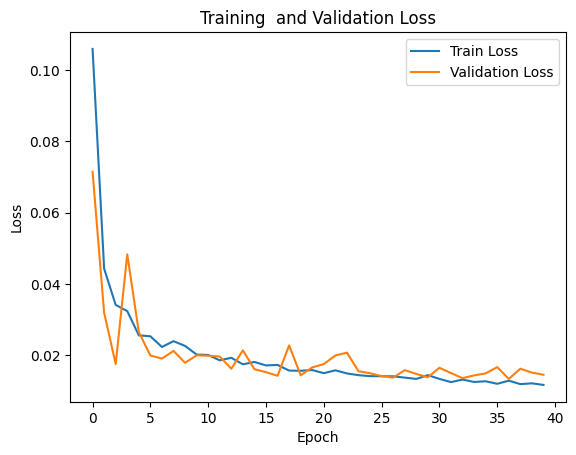

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training  and Validation Loss')
plt.legend()
plt.show()

In [10]:
# Predict values
predicted_values, actual_values = predict(the_model, test_loader)

## Visualize predicted value and actual value

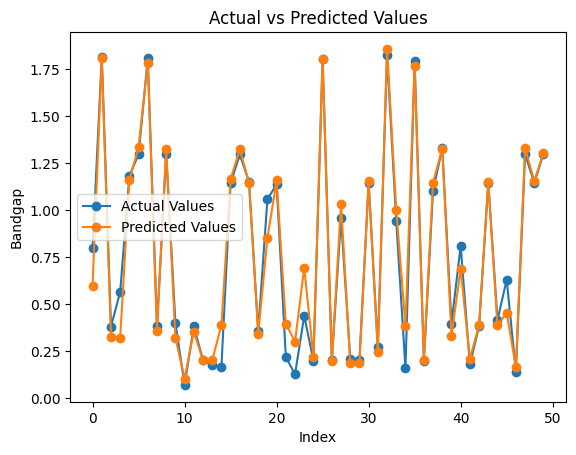

In [11]:
plt.plot(actual_values[100:150], label='Actual Values', marker='o')
plt.plot(predicted_values[100:150], label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('Bandgap')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

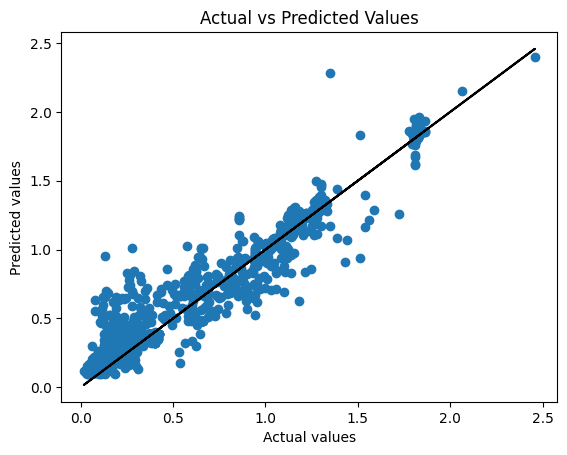

In [12]:
# Produce a graph
plt.scatter(actual_values, predicted_values )
plt.plot(actual_values, actual_values, c="black")
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted Values')
plt.show()

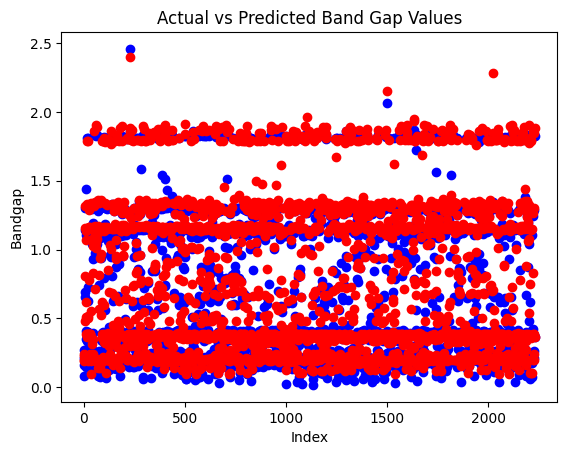

In [13]:
indices = range(len(actual_values))

plt.scatter(indices, actual_values, color='blue', label='Actual')
plt.scatter(indices, predicted_values, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Bandgap')
plt.title('Actual vs Predicted Band Gap Values')
plt.show()